In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from astropy import units as u
from astropy import constants as c
from astropy.cosmology import Planck18 as cosmo
from tqdm import tqdm

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from functools import partial

sys.path.append(os.environ['DM21CM_DIR'])
from dm21cm.preprocessing.accretion import PBHAccretionModel, Mdot_PR, Mdot_BHL
from dm21cm.preprocessing.halo import *
# from dm21cm.preprocessing.hmf import *
from dm21cm.utils import load_h5_dict

sys.path.append(os.environ['DH_DIR'])
from darkhistory import physics as dh_phys

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../../plotting/matplotlibrc')

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/halomod/halo_exclusion.py:18: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  warnings.warn(


# 1. BHL and PR accretion

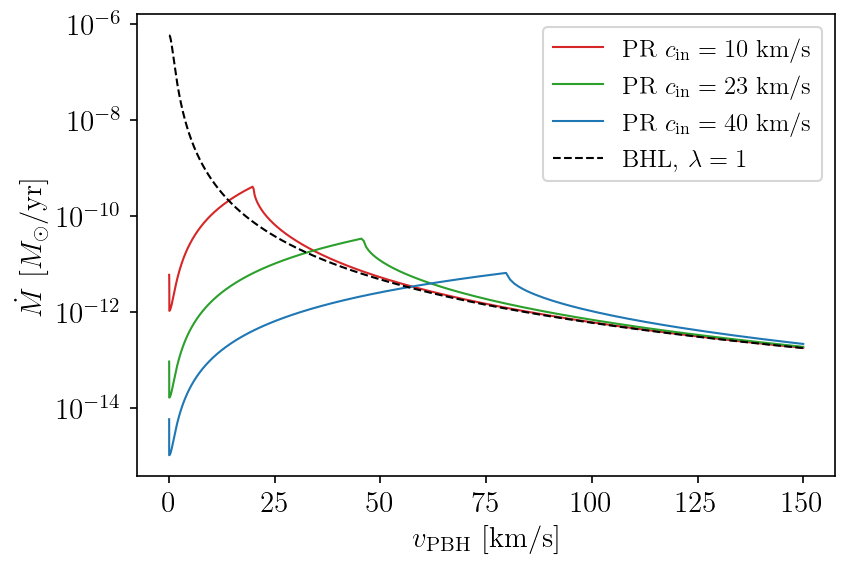

In [2]:
# reproduce PR figure
rho_inf = c.m_p.to(u.g).value * 1e3 # [g/cm^3]
c_inf = 1 # [km/s]
c_in = 23 # [km/s]
M = 10 # [M_sun]
v_arr = np.geomspace(0.001, 150, 1000) # [km/s]
Mdot_PR10_arr = np.array([Mdot_PR(M, rho_inf, v, 10, c_inf) for v in v_arr])
Mdot_PR23_arr = np.array([Mdot_PR(M, rho_inf, v, 23, c_inf) for v in v_arr])
Mdot_PR40_arr = np.array([Mdot_PR(M, rho_inf, v, 40, c_inf) for v in v_arr])
Mdot_BHL_arr = np.array([Mdot_BHL(M, rho_inf, v, None, c_inf) for v in v_arr])

fig, axs = plt.subplots(1, 1, figsize=(6, 4))

axs.plot(v_arr, Mdot_PR10_arr, label=r'PR $c_\mathrm{in}=10$ km/s', lw=1)
axs.plot(v_arr, Mdot_PR23_arr, label=r'PR $c_\mathrm{in}=23$ km/s', lw=1)
axs.plot(v_arr, Mdot_PR40_arr, label=r'PR $c_\mathrm{in}=40$ km/s', lw=1)
axs.plot(v_arr, Mdot_BHL_arr, 'k--', label=r'BHL, $\lambda=1$', lw=1)
axs.set(yscale='log')
axs.set(xlabel=r'$v_\mathrm{PBH}$ [km/s]', ylabel=r'$\dot{M}$ [$M_\odot$/yr]')
axs.legend()
# fig.savefig('Mdot_PR_BHL.pdf', bbox_inches='tight')

# 2. Cosmological PBH: injected energy vs. redshift

In [3]:
# scale of things for one cosmo PBH
from dm21cm.preprocessing.accretion import v_cb_cosmo, rho_in_v_in, v_R_v_D, Mdot_PR, L_ADAF
import dm21cm.physics as phys

z = 15
m_PBH = 100 # [M_sun]
c_in = 23 # [km/s]

#--- taken from dm21cm.preprocessing.accretion.PBHAccretionModel ---
rho_inf = (cosmo.critical_density(z) * cosmo.Ob(z)).to(u.g/u.cm**3) # [g/cm^3]
T_K = dh_phys.Tm_std(1+z) # [eV]
c_inf = np.sqrt(5/3 * T_K * u.eV / c.m_p).to(u.km/u.s).value # [km/s]
v_cb = v_cb_cosmo(z) # [km/s]
#------

print(f'rho_inf = {rho_inf:.3e}')
print(f'rho_inf/m_p = {(rho_inf / c.m_p).to(u.cm**-3):.3e}')
print(f'n_B = {phys.n_B * (1+z)**3:.3e} 1 / cm3')
print(f'n_A = {phys.n_A * (1+z)**3:.3e} 1 / cm3')
print(f'T_K = {(T_K * u.eV / c.k_B).to(u.K):.3f}')
print(f'c_inf = {c_inf:.3f} km/s')
print(f'v_cb = {v_cb:.3f} km/s')

v_R, v_D = v_R_v_D(c_in, c_inf)
rho_in, v_in = rho_in_v_in(rho_inf.value, v_cb, c_in, c_inf)

print()
print(f'v_R = {v_R:.3f} km/s | v_D = {v_D:.3f} km/s')
print(f'rho_in = {rho_in:.3e} g/cm^3')
print(f'rho_in/m_p * A_per_B = {phys.A_per_B * (rho_in * u.g/u.cm**3 / c.m_p).to(u.cm**-3):.3e}')
print(f'v_in = {v_in:.3f} km/s')

mdot = 4 * np.pi * (rho_in*u.g/u.cm**3) * (c.G**2 * (m_PBH*u.M_sun)**2) / (v_in**2 + c_in**2)**(3/2) / (u.km/u.s)**3
mdot = mdot.to(u.Msun/u.yr)
print(f'acc rate = {mdot:.3e}')

l = L_ADAF(mdot.value, m_PBH)
print(f'L_ADAF = {l:.3e} solMass / yr')
print(f'L_ADAF = {(l*u.Msun/u.yr*c.c**2).to(u.erg/u.s):.3e}')
print(f'epsilon = {l / mdot.value:.3e}')

rho_inf = 1.725e-27 g / cm3
rho_inf/m_p = 1.031e-03 1 / cm3
n_B = 1.031e-03 1 / cm3
n_A = 8.417e-04 1 / cm3
T_K = 5.456 K
c_inf = 0.274 km/s
v_cb = 0.480 km/s

v_R = 45.998 km/s | v_D = 0.002 km/s
rho_in = 4.980e-31 g/cm^3
rho_in/m_p * A_per_B = 2.430e-07 1 / cm3
v_in = 23.000 km/s
acc rate = 5.083e-19 solMass / yr
L_ADAF = 3.218e-26 solMass / yr
L_ADAF = 1.822e+21 erg / s
epsilon = 6.331e-08


In [4]:
# electron scattering opacity
(c.sigma_T / c.m_p).to(u.cm**2/u.g)

<Quantity 0.39772639 cm2 / g>

$$f(v)dv=\left(\frac{m}{2\pi kT}\right)^{3/2} 4\pi v^2 \exp\left[-\frac{mv^2}{2kT}\right]dv=\left(\frac{3}{2\pi v_\text{rms}^2}\right)^{3/2} 4\pi v^2 \exp\left[-\frac{3v^2}{2v_\text{rms}^2}\right]dv, \qquad v_\text{rms}^2 = \frac{3kT}{m}$$

In [5]:
z_arr = np.geomspace(5, 1000, 100)

am_PR = PBHAccretionModel(m_PBH=100, f_PBH=1, accretion_type='PR-ADAF', c_in=23)
am_BHL = PBHAccretionModel(m_PBH=100, f_PBH=1, accretion_type='BHL-ADAF')

In [6]:
Mdot_BHL_s = []
Mdot_PR_s = []
L_BHL_s = []
L_PR_s = []

for i, z in enumerate(tqdm(z_arr)):

    # n_PBH = f_PBH * (cosmo.critical_density(z) * cosmo.Odm(z) / (M_PBH * u.M_sun)).to(u.cm**-3).value # [cm^-3]

    Mdot_BHL_s.append(am_BHL.Mdot_cosmo_single_PBH(z))
    Mdot_PR_s.append(am_PR.Mdot_cosmo_single_PBH(z))
    L_BHL_s.append(am_BHL.L_cosmo_single_PBH(z))
    L_PR_s.append(am_PR.L_cosmo_single_PBH(z))

100%|██████████| 100/100 [00:01<00:00, 71.93it/s]


Text(0.5, 0.98, 'Cosmological contribution')

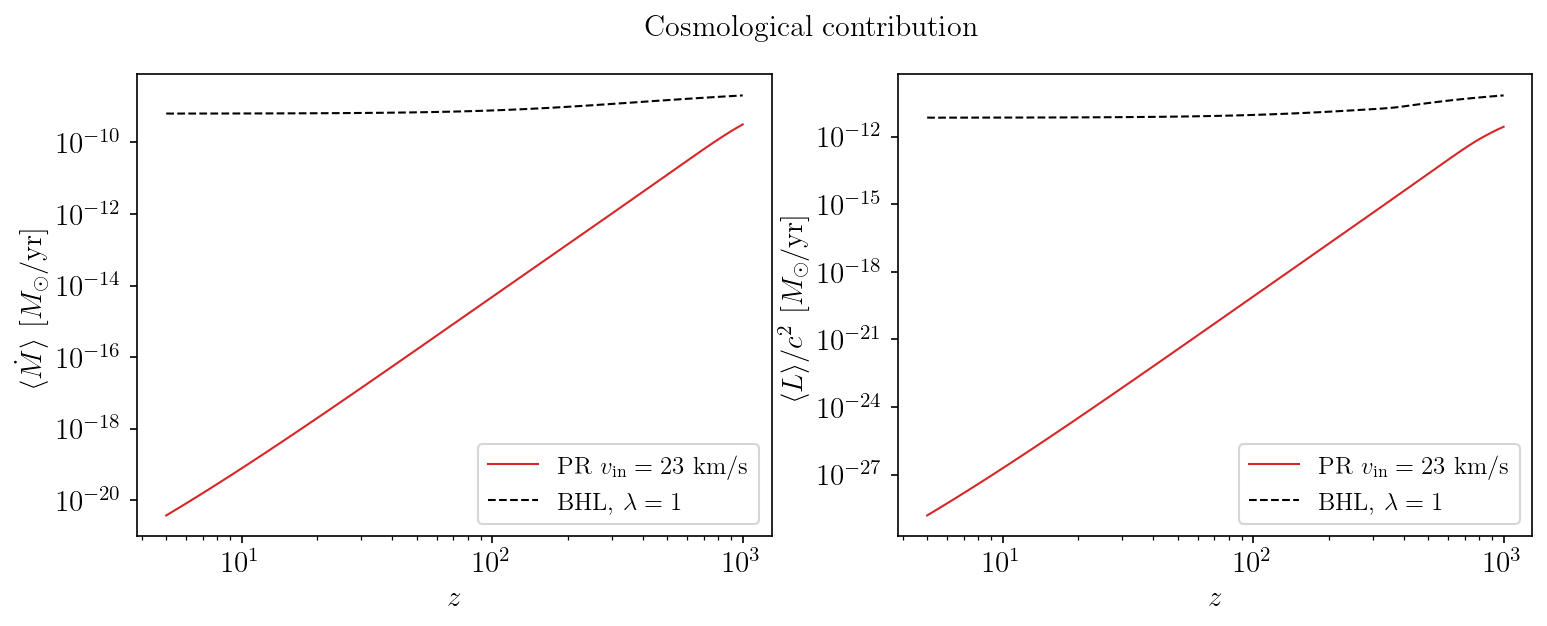

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(z_arr, Mdot_PR_s, lw=1, label='PR $v_\mathrm{in}=23$ km/s')
axs[0].plot(z_arr, Mdot_BHL_s, 'k--', lw=1, label='BHL, $\lambda=1$')
axs[0].set(xscale='log', yscale='log')
axs[0].set(xlabel=r'$z$', ylabel=r'$\langle\dot{M}\rangle$ [$M_\odot$/yr]')
axs[0].legend()

axs[1].plot(z_arr, L_PR_s, lw=1, label='PR $v_\mathrm{in}=23$ km/s')
axs[1].plot(z_arr, L_BHL_s, 'k--', lw=1, label='BHL, $\lambda=1$')
axs[1].set(xscale='log', yscale='log')
axs[1].set(xlabel=r'$z$', ylabel=r'$\langle L\rangle/c^2$ [$M_\odot$/yr]')
axs[1].legend()

fig.suptitle('Cosmological contribution')

# 3. Halo contribution: Example halo

$$L_\text{halo}=\int_V n_\text{PBH}L_\text{PBH}=\frac{f}{M_\text{PBH}}\int_0^{r_\Delta}4\pi r^2dr \rho(r)L()$$

In [8]:
am = PBHAccretionModel(m_PBH=100, f_PBH=1, accretion_type='PR-ADAF', c_in=23)
z = 10
m_halo = 1e8 # [M_sun]
c_halo = cmz(m_halo, z)
print(f'c = {c_halo:.4f}')

c = 4.1005


In [9]:
rho_s, r_s, r_delta = nfw_info(m_halo, c_halo, z)
print(f'rho_s = {rho_s:.4e} M_sun / pc^3')
print(f'r_s = {r_s:.4f} pc')
print(f'r_delta = {r_delta:.4f} pc')

rho_s = 7.3566e-02 M_sun / pc^3
r_s = 319.9855 pc
r_delta = 1312.0986 pc


$$v_\text{rms}^2 = \frac{3kT}{m}\qquad c_\infty^2 = \frac{5kT}{3m}\quad\Rightarrow\quad c_\infty=\sqrt{\frac{5}{9}}~v_\text{rms}$$

In [10]:
f_DM = cosmo.Odm0 / cosmo.Om0
f_SM = cosmo.Ob0 / cosmo.Om0
KM_PER_PC = (1 * u.pc).to(u.km).value

# at various radius
r_list = [1e-4 * r_s, 1e-3 * r_s, 1e-2 * r_s, 1e-1 * r_s, r_s, 0.9 * r_delta]
v_km_s_list = []
L_s_list = []
f_s_list = []
n_PBH_list = []

for r in r_list:
    ve = get_ve(r, rho_s, r_s, r_delta)
    v0 = get_v0_jeans(r, rho_s, r_s, r_delta)
    rho = nfw_density(r, rho_s, r_s) # [M_sun/pc^3]
    n_PBH = am.f_PBH * f_DM * (rho * u.M_sun / u.pc**3 / (am.m_PBH * u.M_sun)).to(u.pc**-3).value # [pc^-3]
    n_PBH_list.append(n_PBH)
    rho_inf = f_SM * (rho * u.M_sun / u.pc**3).to(u.g/u.cm**3).value # [g/cm^3]

    # cosmological c_inf
    # T_K = phys.Tm_std(1+z) # [eV]
    # c_inf = np.sqrt(5/3 * T_K * u.eV / c.m_p).to(u.km/u.s).value # [km/s]
    
    # halo c_inf
    c_inf = jnp.sqrt(5/9) * v0 * KM_PER_PC # [km/s]

    print(f'r = {r:.4e} pc | n_PBH = {n_PBH:.4e} pc^-3 | rho_inf = {rho_inf:.4e} g/cm^3 | c_inf = {c_inf:.4f} km/s')

    v_pc_s = jnp.linspace(0, ve, 1000)
    v_km_s = v_pc_s * KM_PER_PC
    v_km_s_list.append(v_km_s)
    L_s = am.L_func_v(am.m_PBH, rho_inf, v_km_s, am.c_in, c_inf)
    L_s_list.append(L_s)

    f_s = dm_rest_v_rel_dist_unnorm(v_pc_s, ve, v0)
    f_s /= jnp.trapz(f_s, v_km_s)
    f_s_list.append(f_s)

r = 3.1999e-02 pc | n_PBH = 2.4768e+01 pc^-3 | rho_inf = 3.1488e-20 g/cm^3 | c_inf = 0.8281 km/s
r = 3.1999e-01 pc | n_PBH = 2.4723e+00 pc^-3 | rho_inf = 3.1432e-21 g/cm^3 | c_inf = 2.1876 km/s
r = 3.1999e+00 pc | n_PBH = 2.4285e-01 pc^-3 | rho_inf = 3.0874e-22 g/cm^3 | c_inf = 5.2674 km/s
r = 3.1999e+01 pc | n_PBH = 2.0473e-02 pc^-3 | rho_inf = 2.6029e-23 g/cm^3 | c_inf = 10.3161 km/s
r = 3.1999e+02 pc | n_PBH = 6.1932e-04 pc^-3 | rho_inf = 7.8736e-25 g/cm^3 | c_inf = 12.8260 km/s
r = 1.1809e+03 pc | n_PBH = 3.0512e-05 pc^-3 | rho_inf = 3.8791e-26 g/cm^3 | c_inf = 5.8288 km/s


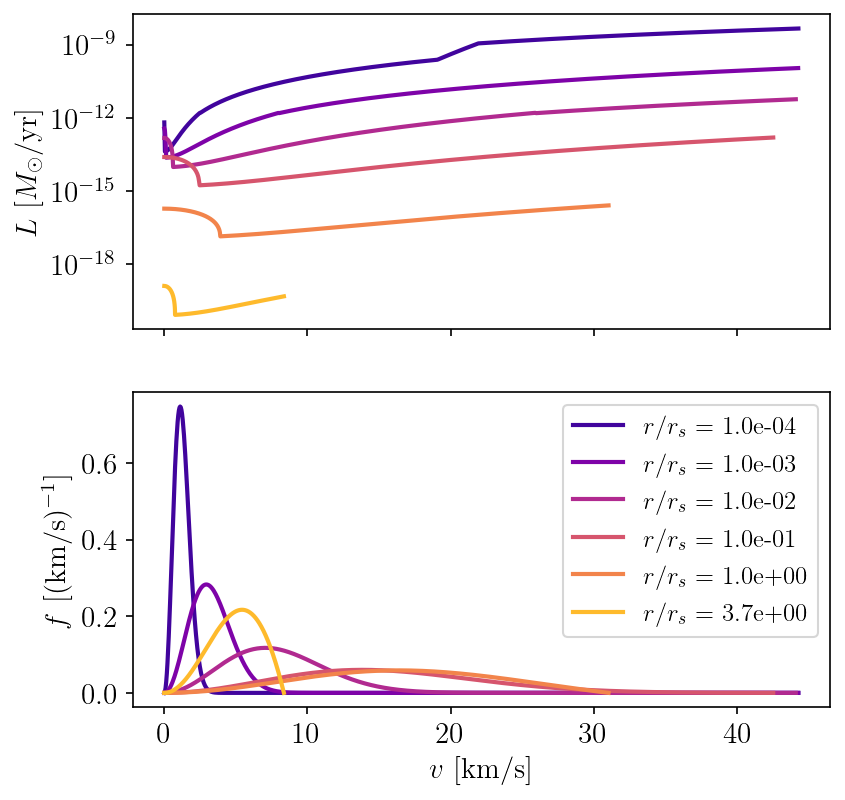

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

for i in range(len(r_list)):
    x = 0.1 + 0.15 * i
    color = mpl.colormaps['plasma'](x)

    r = r_list[i]

    ax = axs[0]
    ax.plot(v_km_s_list[i], L_s_list[i], color=color, label=fr'$r/r_s$ = {r_list[i]/r_s:.2f}')
    ax.set(ylabel=r'$L$ [$M_\odot$/yr]')
    ax.set(yscale='log')
    
    ax = axs[1]
    ax.plot(v_km_s_list[i], f_s_list[i], color=color, label=fr'$r/r_s$ = {r_list[i]/r_s:.1e}')
    ax.set(xlabel=r'$v$ [km/s]', ylabel=r'$f$ [(km/s)$^{-1}$]')
    ax.legend()

fig.savefig('halo-L-f-v.pdf', bbox_inches='tight')

## 3.2 Organization

In [12]:
am.L_halo(m_halo, c_halo, z)

Array(3.60263899e-10, dtype=float64)

# 4. Sum over HMF

In [13]:
hmfd = load_h5_dict("../../data/pwave/m_data.h5")

m_s = hmfd['m_range'] # [M_sun]
z_s = hmfd['z_range']
dndm_PS = hmfd['dNdM'] # [M_sun^-1 Mpc^-3]
print(dndm_PS.shape)
dndm_ST = hmfd['dNdM_ST'] # [M_sun^-1 Mpc^-3]

RHO_M = cosmo.Om0 * cosmo.critical_density0.to(u.M_sun / u.Mpc**3).value

(51, 4001)


## 4.0 Estimates

10.0


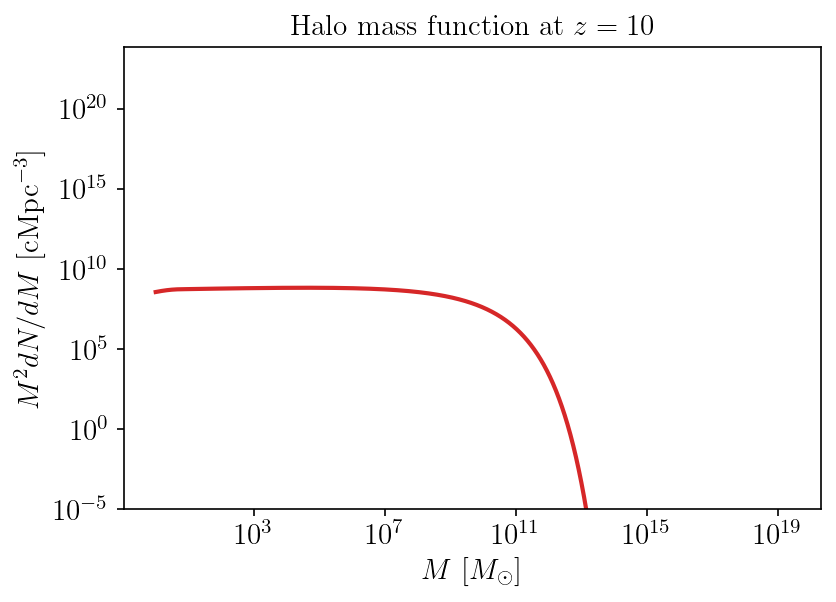

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
print(z_s[10])
ax.plot(m_s, m_s**2*dndm_ST[10])
ax.set(xscale='log', yscale='log', ylim=(1e-5, None))
ax.set(xlabel=r'$M$ [$M_\odot$]', ylabel=r'$M^2 dN/dM$ [cMpc$^{-3}$]', title=r'Halo mass function at $z=10$');

In [15]:
# collapsed fraction
rho_coll_ST = np.trapz(m_s[None, :] * dndm_ST, m_s, axis=1)
rho_coll_ST[10] / RHO_M

0.2956715843079006

In [16]:
z = 10
m_halo_s = np.logspace(0, 8, 5)
c_halo_s = cmz(m_halo_s, z)

for m, c in zip(m_halo_s, c_halo_s):
    print(f'm = {m:8.1e} Msun | c = {c:8.3f}', end=' ')
    rho_s, r_s, r_delta = nfw_info(m, c, z)
    v0 = get_v0_jeans(r_s, rho_s, r_s, r_delta) * KM_PER_PC # [km/s]
    print(f'| r_s = {r_s:8.2f} pc', end=' ')
    print(f'| v0_jeans at r_s = {v0:8.3f} km/s')

m =  1.0e+00 Msun | c =   15.560 | r_s =     0.18 pc | v0_jeans at r_s =    0.049 km/s
m =  1.0e+02 Msun | c =   19.269 | r_s =     0.68 pc | v0_jeans at r_s =    0.239 km/s
m =  1.0e+04 Msun | c =   10.928 | r_s =     5.57 pc | v0_jeans at r_s =    0.960 km/s
m =  1.0e+06 Msun | c =    6.410 | r_s =    44.10 pc | v0_jeans at r_s =    3.989 km/s
m =  1.0e+08 Msun | c =    4.100 | r_s =   319.99 pc | v0_jeans at r_s =   17.208 km/s


## 4.1 $f_\mathrm{coll}$

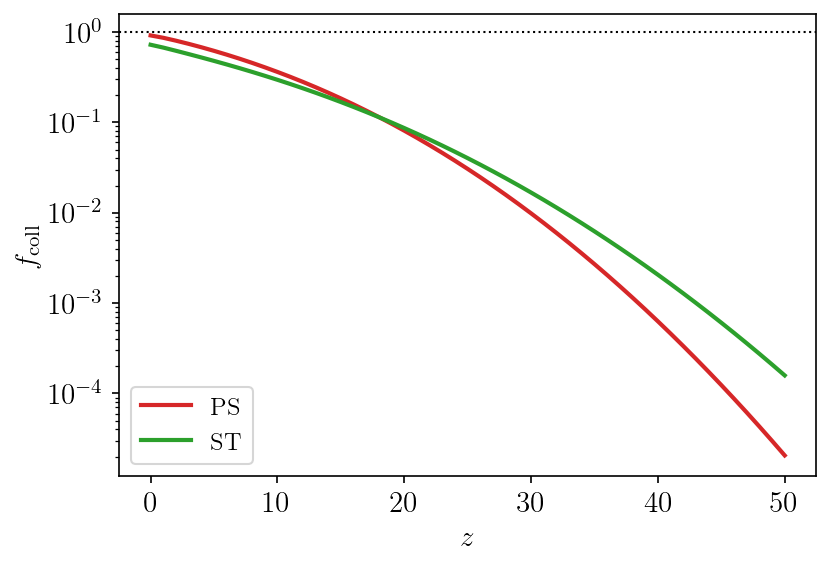

In [17]:
# collapsed fraction
rho_coll_PS = np.trapz(m_s[None, :] * dndm_PS, m_s, axis=1) # [M_sun cMpc^-3]
rho_coll_ST = np.trapz(m_s[None, :] * dndm_ST, m_s, axis=1) # [M_sun cMpc^-3]
f_coll_PS = rho_coll_PS / RHO_M # RHO_M is for present day [M_sun cMpc^-3]
f_coll_ST = rho_coll_ST / RHO_M

fig, axs = plt.subplots(1, 1, figsize=(6, 4))

ax = axs
ax.plot(z_s, f_coll_PS, label='PS')
ax.plot(z_s, f_coll_ST, label='ST')
ax.set(yscale='log')
ax.axhline(1, color='k', ls=':', lw=1)
ax.set(xlabel=r'$z$', ylabel=r'$f_\mathrm{coll}$')
ax.legend()

## 4.2 L-m

In [18]:
# Resample m_s
hmfd = load_h5_dict("../../data/pwave/m_data.h5")

res_m = 1000
m_s = np.geomspace(hmfd['m_range'][0], hmfd['m_range'][-1], res_m)
dndm_PS = np.exp([np.interp(np.log(m_s), np.log(hmfd['m_range']), np.log(hmfd['dNdM'][i])) for i in range(len(z_s))])
dndm_ST = np.exp([np.interp(np.log(m_s), np.log(hmfd['m_range']), np.log(hmfd['dNdM_ST'][i])) for i in range(len(z_s))])

/tmp/ipykernel_3383677/1559452433.py:6: RuntimeWarning: divide by zero encountered in log
  dndm_PS = np.exp([np.interp(np.log(m_s), np.log(hmfd['m_range']), np.log(hmfd['dNdM'][i])) for i in range(len(z_s))])
/tmp/ipykernel_3383677/1559452433.py:7: RuntimeWarning: divide by zero encountered in log
  dndm_ST = np.exp([np.interp(np.log(m_s), np.log(hmfd['m_range']), np.log(hmfd['dNdM_ST'][i])) for i in range(len(z_s))])


In [19]:
am = PBHAccretionModel(m_PBH=100, f_PBH=1, accretion_type='PR-ADAF', c_in=23)
z = 10
m_halo_s = jnp.asarray(m_s) # [M_sun]
c_halo_s = jnp.asarray(cmz(m_halo_s, z))

In [20]:
L_halo_vmap = jax.jit(jax.vmap(am.L_halo, in_axes=(0, 0, None)))

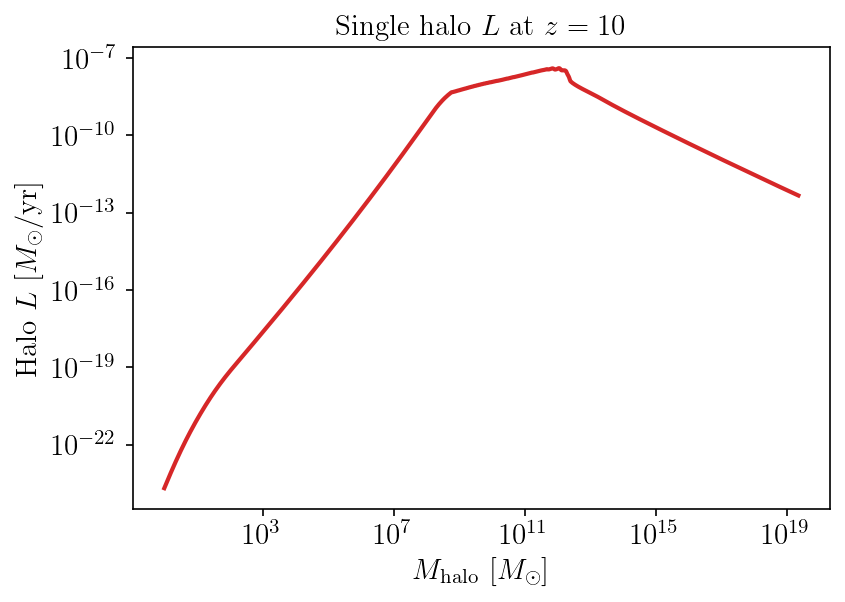

In [21]:
L_s = L_halo_vmap(m_halo_s, c_halo_s, z)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(m_s, L_s)
ax.set(xscale='log', yscale='log')
ax.set(xlabel=r'$M_\mathrm{halo}$ [$M_\odot$]', ylabel=r'Halo $L$ [$M_\odot$/yr]', title=r'Single halo $L$ at $z=10$');

In [22]:
L_density_halo_s = []
for i_z, z in enumerate(tqdm(z_s)):
    L_s = L_halo_vmap(m_halo_s, c_halo_s, z) # [M_sun/yr]
    dndm = dndm_ST[i_z] # [M_sun^-1 cMpc^-3]
    L_density_halo = jnp.trapz(L_s * dndm, m_s) # [M_sun/yr cMpc^-3]
    L_density_halo_s.append(L_density_halo)

100%|██████████| 51/51 [00:03<00:00, 14.48it/s]


## 4.3 Cosmological contribution

In [23]:
# collapsed fraction
rho_coll_PS = np.trapz(m_s[None, :] * dndm_PS, m_s, axis=1) # [M_sun cMpc^-3]
rho_coll_ST = np.trapz(m_s[None, :] * dndm_ST, m_s, axis=1) # [M_sun cMpc^-3]
f_coll_PS = rho_coll_PS / RHO_M # RHO_M is for present day [M_sun cMpc^-3]
f_coll_ST = rho_coll_ST / RHO_M

In [24]:
L_cosmo_density_s = [am.L_cosmo_density(z, f_coll) for z, f_coll in zip(z_s, f_coll_ST)]

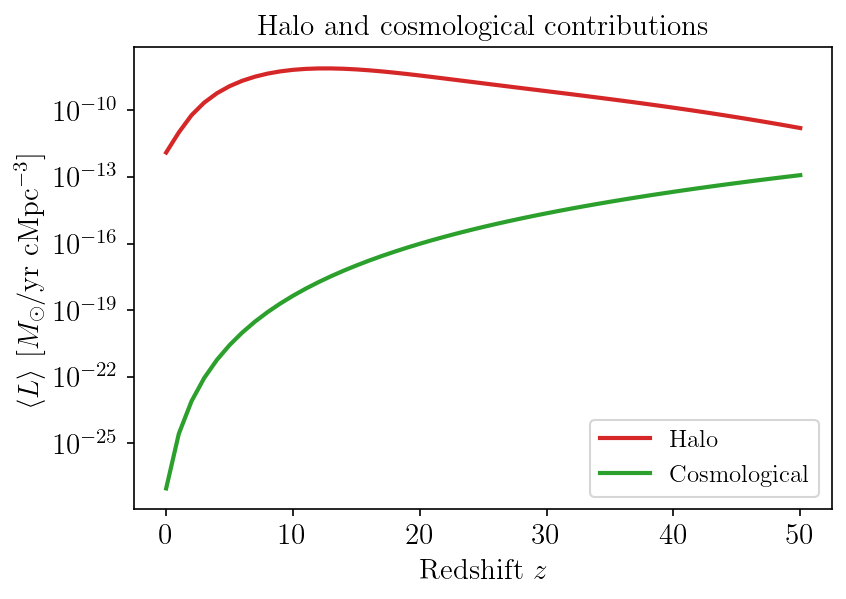

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

ax = axs
ax.plot(z_s, L_density_halo_s, label='Halo')
ax.plot(z_s, L_cosmo_density_s, label='Cosmological')
ax.set(yscale='log')
ax.set(xlabel=r'Redshift $z$', ylabel=r'$\langle L\rangle$ [$M_\odot$/yr cMpc$^{-3}$]', title=r'Halo and cosmological contributions')
ax.legend()

fig.savefig('L_halo_cosmo.pdf', bbox_inches='tight')